In [3]:
!nvidia-smi

Tue May 25 00:06:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install tensorflow-gpu

     |████████████████████████████████| 454.3MB 37kB/s 
     |████████████████████████████████| 6.0MB 36.5MB/s 
     |████████████████████████████████| 1.2MB 36.0MB/s 
     |████████████████████████████████| 4.0MB 34.0MB/s 
     |████████████████████████████████| 471kB 55.1MB/s 
     |████████████████████████████████| 4.0MB 43.7MB/s 
     |████████████████████████████████| 4.9MB 25.7MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.5.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installatio

In [4]:
import os

from google.colab import drive
drive.mount('/content/drive')

train_path = '/content/drive/My Drive/Colon/train'
valid_path = '/content/drive/My Drive/Colon/valid'

model_path = '/content/drive/My Drive/Colon/model'

# train_list = os.listdir(valid_path + '/positive')
# print(len(train_list))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
64


In [6]:
import keras 
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [7]:
# Making data
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split=0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 subset="training",
                                                 class_mode = 'categorical')

validation_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 subset="validation",
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical')

STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=validation_set.n//validation_set.batch_size
STEP_SIZE_TEST=test_set.n//test_set.batch_size

Found 439 images belonging to 2 classes.
Found 109 images belonging to 2 classes.
Found 128 images belonging to 2 classes.


In [8]:
# Building model
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#here [3] denotes for RGB images(3 channels)

#don't train existing weights
for layer in vgg.layers:
 layer.trainable = False
 
x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(),
                    metrics=['accuracy'])
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [9]:
# Train model on train and validation set
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
checkpoint = ModelCheckpoint(model_path, 
                               verbose=1, save_best_only=True)
callbacks = [checkpoint, lr_reducer]
start = datetime.now()
history = model.fit_generator(training_set, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    epochs = 10, verbose=5, 
                    validation_data = validation_set, 
                    validation_steps = STEP_SIZE_VALID)
duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Training completed in time:  0:46:38.037501


In [10]:
# save model
model.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colon/model/assets


In [11]:
# Evaluating our model on test data set
score = model.evaluate(test_set)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

16/16 [==============================] - 130s 8s/step - loss: 0.7502 - accuracy: 0.7500
Test Loss: 0.7501880526542664
Test accuracy: 0.75


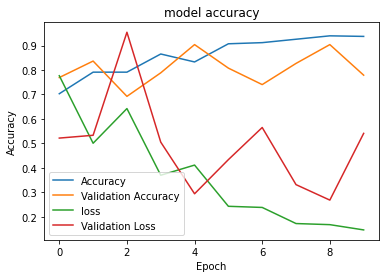

In [12]:
# Visualization
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Validation Accuracy','loss','Validation Loss'])
plt.show()